# Test models and see performance

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from argparse import ArgumentParser
import yaml
from typing import Dict, Tuple, Union, Any
import pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt

from models import MODELS

In [34]:
# Load config file

config_path = "configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [35]:

def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y
    else:
      return X, y

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    # Sample 50000 data pairs
    sampled_df = concatenated_df.sample(50000, random_state=config['Seed'])
    X = sampled_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = sampled_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y
    else:
      return X, y

  else:
      return None


X_test, y_test = prepare_data(config)

In [36]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

#############################################
# TEST
if model_name == 'GPR': # Active learning
  y_pred, y_std = model.predict(X_test, return_std=True)
  print('Mean test std', y_std.mean()) 
  model.test_scores(y_test=y_test, y_pred=y_pred)
else: 
  y_pred = model.predict(X_test=X_test)
  model.test_scores(y_test=y_test, y_pred=y_pred)

Test RMSE: 1.5190654928272445


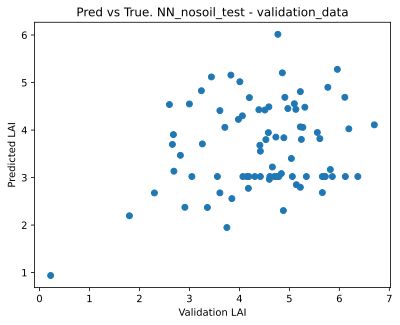

In [37]:
# Plot ypred vs ytest

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.set_xlabel('Validation LAI')
ax.set_ylabel('Predicted LAI')
ax.set_title(f'Pred vs True. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
plt.savefig(f'trained_models/pred_vs_true_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

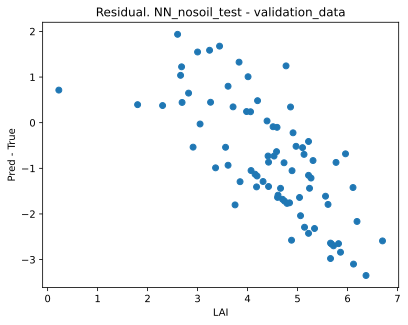

In [38]:
# Plot residuals

fig, ax = plt.subplots()
res = y_pred.squeeze() - y_test
ax.scatter(y_test, res)
ax.set_xlabel('LAI')
ax.set_ylabel('Pred - True')
ax.set_title(f'Residual. {model_filename.split(".pkl")[0].split("/")[-1]} - {config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}')
plt.savefig(f'trained_models/residual_{model_filename.split(".pkl")[0].split("/")[-1].split(".pkl")[0]}_{config["Data"]["test_data_path"].split("/")[-1].split(".pkl")[0]}.png')

# Test models in low LAI (<4)

In [20]:
# Load config file

config_path = "configs/config_NN.yaml"
with open(config_path, "r") as config_file:
      config = yaml.safe_load(config_file)

In [21]:

def prepare_data(config: dict) -> Union[Tuple[np.array, np.array, np.array, np.array], None]:
  ''' 
  Load data and prepare training and testing sets

  :param config: dictionary of configuration parameters
  :returns: X pd.DataFrame and y pd.Series for training and test sets 
  '''
  data_path = config['Data']['test_data_path']

  if isinstance(data_path, str):
    df = pd.read_pickle(data_path)
    X = df[config['Data']['train_cols']]
    y = df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y
    else:
      return X, y

  elif isinstance(data_path, list):
    # Assuming all files in the list are pickled DataFrames
    dfs = [pd.read_pickle(path) for path in data_path]
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    X = concatenated_df[config['Data']['train_cols']] #  concatenated_df[config['Data']['train_cols']]
    y = concatenated_df[config['Data']['target_col']] #  concatenated_df[config['Data']['target_col']]
    if config['Data']['normalize']:
      # Load scaler
      scaler_path = config['Model']['save_path'].split('.')[0] + '_scaler.pkl'
      with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
      # Normalize
      X = scaler.transform(X)
      return X, y
    else:
      return X, y

  else:
      return None


X_test, y_test = prepare_data(config)

In [22]:
# Keep only low LAI values (<4)

X_low = X_test[y_test < 4]
y_low = y_test[y_test < 4]

In [23]:
#############################################
# MODEL
save_model = config['Model'].pop('save')
model_name = config['Model']['name']
model_filename = config['Model'].pop('save_path') 
with open(model_filename, 'rb') as f:
  model = pickle.load(f)

In [24]:
# Calculate RMSE
y_pred = model.predict(X_test=X_low)
model.test_scores(y_test=y_low, y_pred=y_pred)


Test RMSE: 0.7352794112827835


In [14]:
X_low.shape

(46, 10)